In [26]:
import pandas as pd

# Specify the correct path to your Excel file
excel_file_path = "/workspaces/minor_hw/Salt.xls"

# Read the Excel file into a DataFrame
df = pd.read_excel(excel_file_path)

# Display the DataFrame
df["month"] = df.index
df = df[['month', 'salt']]

## Кривые роста

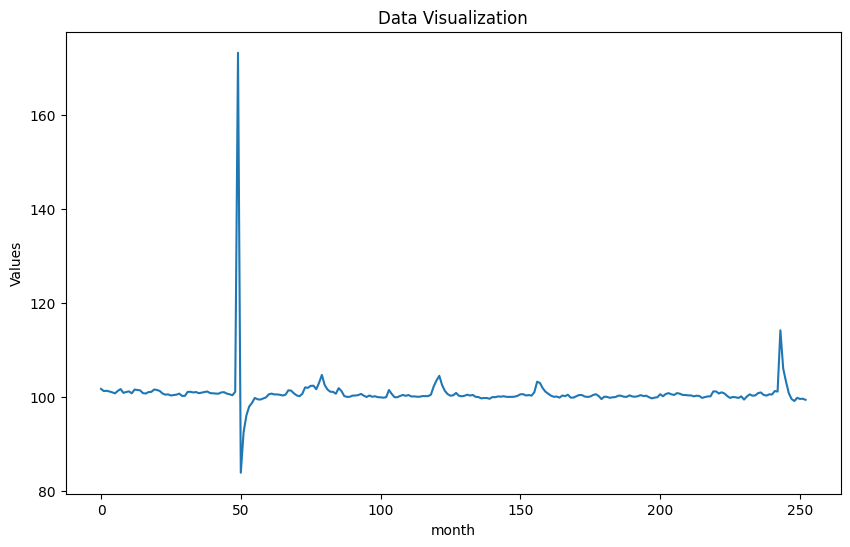

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df['month'], df['salt'])
plt.title('Data Visualization')
plt.xlabel('month')
plt.ylabel('Values')
plt.show()

In [28]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Assuming you have the input data in X and the corresponding output data in y
X = np.array(df['month']).reshape(-1, 1)
y = np.array(df['salt'])

# Transform the input data to include polynomial features
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X)

# Fit the polynomial regression model
model = LinearRegression()
model.fit(X_poly, y);

# Predict the output for new input data
predicted_y = model.predict(X_poly)

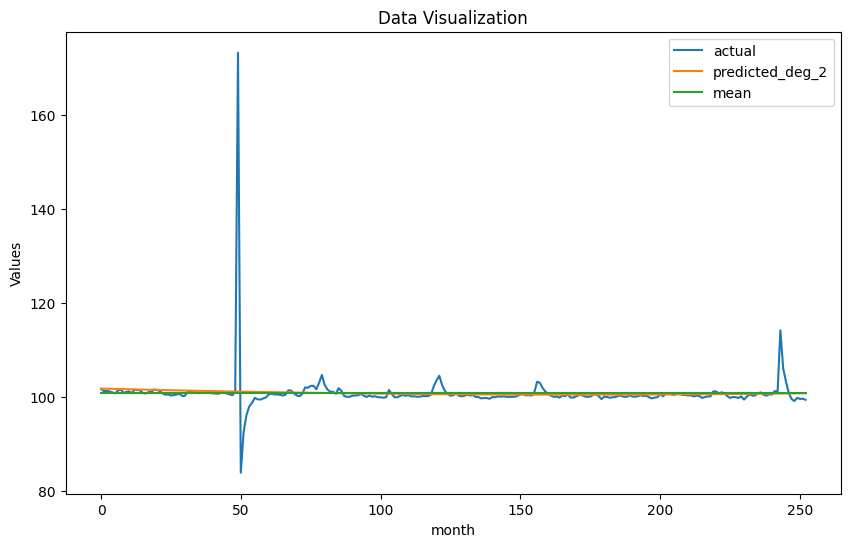

In [29]:
plt.figure(figsize=(10,6))
plt.plot(df['month'], df['salt'], label='actual')
plt.plot(df['month'], predicted_y, label='predicted_deg_2')
plt.title('Data Visualization')
plt.xlabel('month')
plt.ylabel('Values')
plt.plot([df['salt'].mean()] * len(df), label='mean')
plt.legend()

в реальности ряд выглядит так, что у него нулевой тренд. Посчитаем MSE для модели и константной модели. 

In [30]:
import pandas as pd
from sklearn.metrics import mean_squared_error

# Calculate the mean squared error for the fitted model
mse_model = mean_squared_error(df['salt'], predicted_y)

# Calculate the mean squared error for the constant model
constant_model = [df['salt'].mean()] * len(df)
mse_constant = mean_squared_error(df['salt'], constant_model)

# Create a dataframe to store the results
results_df = pd.DataFrame({'Model Name': ['Fitted Model', 'Constant Model'],
                           'MSE': [mse_model, mse_constant]})

results_df

,Model Name,MSE
0,Fitted Model,23.533298
1,Constant Model,23.661005


видно, что разница MSE между моделью и константной моделью несущественнана, поэтому можно сделать вывод, что тренд в ряда выглядит нулевым.

1. Первые аномалии: около 50-го месяца
    - Описание: На графике наблюдается резкое увеличение значений, за которым следует сильное падение и затем восстановление к нормальному уровню.
    - Экономическое обоснование: Это может быть связано с экономическим или политическим событием. Например, возможным объяснением может быть временный дефицит соли из-за проблем с доставкой или производства, что привело к резкому увеличению цены, а затем вмешательству правительства или рыночных сил для стабилизации ситуации.

2. Вторые аномалии: около 240-го месяца
    - Описание: Еще одна менее выраженная аномалия наблюдается ближе к концу графика, около 240-го месяца, где цены опять поднимаются вверх и затем возвращаются к нормальным значениям.
    - Экономическое обоснование: Это также может быть связано с краткосрочными рыночными колебаниями. Например, временная нехватка товаров на рынке, колебания спроса и предложения или другие временные препятствия в поставках соли.



Информация о соляном кризисе 2006 года на основе Яндекса:
Соляной кризис 2006 года.
В январе-феврале 2006 года в ряде регионов России цены на пищевую соль выросли с 5-6 руб. до 50 руб. за килограмм. Объемы, обычно продаваемые за месяц, население Воронежской, Липецкой, Тульской, Тамбовской, Челябинской и других областей скупило за несколько дней. Торговые предприятия вводили ограничения на продажу соли в одни руки, но во многих магазинах вскоре были скуплены все запасы.



Используйте тест Чоу для проверки предполагаемых точек структурного сдвига

In [46]:


#!pip install git+https://github.com/ErmakovSemen/chowtest
# мне пришлось форкать репозиторий и менять в нём setup.py, чтобы установить эту библиотеку

## Чоу тест

In [47]:
from chowtest import ChowTest

# Specify the aggregate points
aggregate_points = [50, 240]

for x in aggregate_points:
    # Perform the Chow test
    chow_results = ChowTest(
        X = df[['month']], y =df[['salt']], 
        last_index_in_model_1=x-1,
        first_index_in_model_2=x+1)

    # Print the Chow test results
    if chow_results[1] < 0.05: 
        print('The Chow test indicates that there is a structural break at month {}'.format(aggregate_points[0]))
# Perform the Chow test

The Chow test indicates that there is a structural break at month 50


## Dummy переменные

In [52]:
df['D'] = (df['month'] >= 50).astype(int)

In [55]:
df['XD'] = df['month'] * df['D']

# Добавим константу для регрессионной модели
X = sm.add_constant(df[['month', 'D', 'XD']])
y = df['salt']

# Оценка модели
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   salt   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     6.441
Date:                Wed, 19 Jun 2024   Prob (F-statistic):           0.000323
Time:                        16:36:39   Log-Likelihood:                -749.76
No. Observations:                 253   AIC:                             1508.
Df Residuals:                     249   BIC:                             1522.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         98.5444      1.316     74.873      0.0

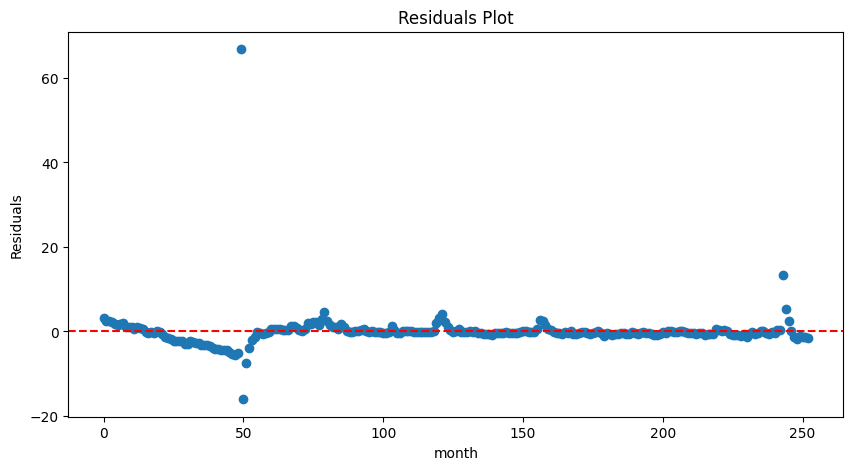

Durbin-Watson statistic: 2.2370579741352


In [57]:
residuals = model.resid

# График остатков
plt.figure(figsize=(10, 5))
plt.plot(df['month'], residuals, marker='o', linestyle='none')
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals Plot")
plt.xlabel("month")
plt.ylabel("Residuals")
plt.show()

# Проверка корреляции остатков (Durbin-Watson test)
dw = sm.stats.durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw}')

#### 1. Результаты регрессии:

##### Коэффициенты модели:
- const (98.5444, p-значение = 0.000): базовый уровень цены до структурного сдвига.
- month (0.1585, p-значение = 0.001): тренд цены до структурного сдвига. Положительное значение указывает на небольшой рост цен до сдвига.
- **D** (1.2417, p-значение = 0.440): эффект структурного сдвига. 
- XD (-0.1540, p-значение = 0.001): изменение тренда после структурного сдвига. Отрицательное значение указывает на изменение тренда после сдвига.

##### Значимость коэффициентов:
- Коэффициенты const, month, и XD имеют p-значения меньше 0.05, что указывает на их статистическую значимость.
- Коэффициент D (1.2417) имеет p-значение 0.440, что указывает на его незначимость. Это может означать, что мгновенное изменение уровня цен в момент сдвига невелико.

##### Модельные параметры:
- R^2: 0.072. Это значение означает, что модель объясняет всего 7.2% вариации в данных. Это относительно низкий уровень объясненной вариации.
- Adjusted R^2: 0.061. Корректировка для количества предикторов, что остаётся низким.
  
##### Значимость модели:
- F-статистика: 6.441 и соответствующее p-значение 0.000323. Это указывает на значимость модели в целом, несмотря на низкое значение R^2.

#### 2. Анализ остатков:
- График остатков: остатки в основном расположены вокруг 0, но есть выбросы.
- Durbin-Watson статистика: 2.237, что близко к 2, указывая на отсутствие автокорреляции остатков.
- Omnibus и Jarque-Bera тесты: p-значения 0.000 указывают на нарушение нормальности остатков.

### Оценка адекватности модели:
1. R^2 значимо низкий: Модель объясняет лишь 7.2% вариации в данных, что может указывать на наличие других факторов, влияющих на цены, которые не были включены в модель. 
2. F-статистика значима: Несмотря на низкий R^2, значимость модели в целом позволяет предполагать, что включенные переменные имеют влияние на цены.
3. Durbin-Watson: значение близко к 2, указывая на отсутствие автокорреляции остатков, что подтверждает адекватность модели в этом аспекте.
4. Нарушение нормальности остатков: Тесты Omnibus и Jarque-Bera указывают на то, что остатки не распределены нормально.

### Заключение:
- Структурный сдвиг: В модели выявлено изменение тренда после 50-го месяца, хотя мгновенное изменение уровня цен в момент сдвига невелико и статистически незначимо.
- Адекватность модели: Модель обладает некоторыми ограничениями, особенно низким значением R^2 и нарушениями нормальности остатков. Это указывает на то, что в данных есть недооцененные факторы, и модель нуждается в доработке.
- Рекомендации: стоит рассмотреть дополнительные переменные, которые могут объяснять вариации в ценах на соль. Возможно включить сезонные эффекты или макроэкономические факторы.
